# Setup Requirements

## Import Libraries

In [5]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

## Specify Paths

In [6]:
dataset_path = 'data/data.csv'
model_save_path = 'model/model.keras'
tflite_save_path = 'model/model.tflite'
label_path = 'data/label.csv'

## Setup Attributes

In [7]:
DIMENSION = 2

NUM_CLASSES = 30

# Preprocess Data

## Load Data

In [8]:
X_dataset = np.loadtxt(dataset_path, delimiter=',', dtype='float32', usecols=list(range(1, (21 * DIMENSION) + 1)))

In [9]:
y_dataset = np.loadtxt(dataset_path, delimiter=',', dtype='int32', usecols=(0))

## Split Train/Test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.8, random_state=RANDOM_SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75, random_state=RANDOM_SEED)

# Build Model

## Construct Model

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * DIMENSION, )),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

## Compile Model

In [12]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


## Setup Callbacks

In [13]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=1)

## Summary

In [14]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               5504      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 30)                990       
                                                                 
Total params: 16830 (65.74 KB)
Trainable params: 16830 (

# Train Model

In [15]:
model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_val, y_val),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/50


5016/5069 [============================>.] - ETA: 0s - loss: 0.8990 - accuracy: 0.6985
Epoch 1: saving model to model\model.keras
5069/5069 [==============================] - 5s 929us/step - loss: 0.8945 - accuracy: 0.7000 - val_loss: 0.3628 - val_accuracy: 0.8674
Epoch 2/50
5005/5069 [============================>.] - ETA: 0s - loss: 0.4048 - accuracy: 0.8657
Epoch 2: saving model to model\model.keras
5069/5069 [==============================] - 5s 944us/step - loss: 0.4042 - accuracy: 0.8660 - val_loss: 0.2111 - val_accuracy: 0.9169
Epoch 3/50
5058/5069 [============================>.] - ETA: 0s - loss: 0.3008 - accuracy: 0.9070
Epoch 3: saving model to model\model.keras
5069/5069 [==============================] - 5s 926us/step - loss: 0.3012 - accuracy: 0.9069 - val_loss: 0.1654 - val_accuracy: 0.9537
Epoch 4/50
5057/5069 [============================>.] - ETA: 0s - loss: 0.2477 - accuracy: 0.9244
Epoch 4: saving model to model\model.keras
5069/5069 [==================

# Evaluate Model

## Plot Confusion Matrix

In [16]:
with open(label_path,encoding='utf-8-sig') as f:
		classifier_labels = csv.reader(f)
		classifier_labels = [
			row[0] for row in classifier_labels
		]

In [17]:
print(classifier_labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'Good', 'Bad', 'Noise']


423/423 [==============================] - 0s 514us/step


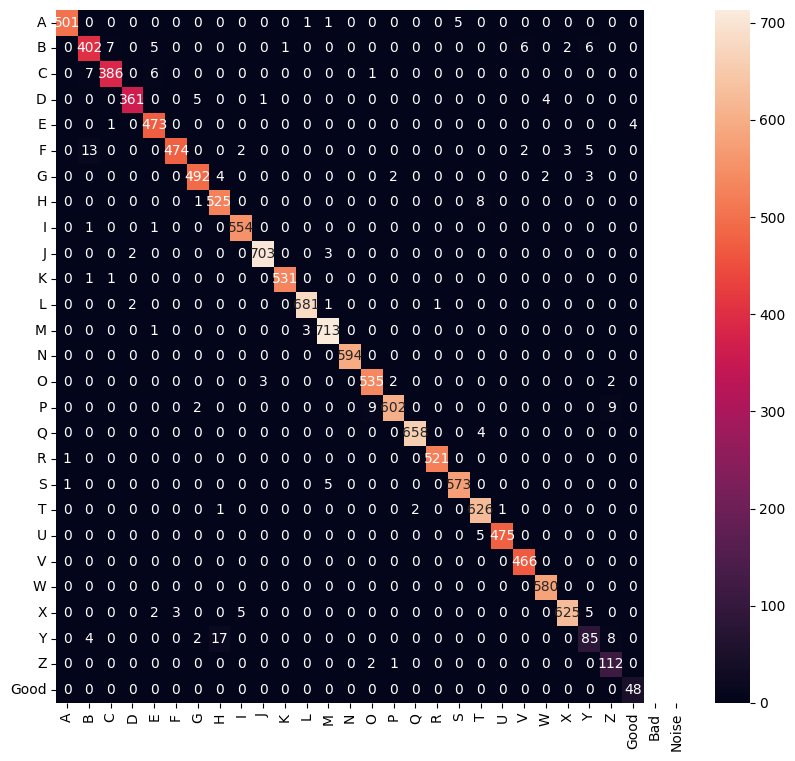

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       508
           1       0.94      0.94      0.94       429
           2       0.98      0.96      0.97       400
           3       0.99      0.97      0.98       371
           4       0.97      0.99      0.98       478
           5       0.99      0.95      0.97       499
           6       0.98      0.98      0.98       503
           7       0.96      0.98      0.97       534
           8       0.99      1.00      0.99       556
          10       0.99      0.99      0.99       708
          11       1.00      1.00      1.00       533
          12       0.99      0.99      0.99       685
          13       0.99      0.99      0.99       717
          14       1.00      1.00      1.00       594
          15       0.98      0.99      0.98       542
          16       0.99      0.97      0.98       622
          17       1.00      0.99      1.00       662
     

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(10, 9))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False, xticklabels=classifier_labels, yticklabels=classifier_labels)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)


## Accuracy and Loss

In [19]:
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=8)

1690/1690 [==============================] - 1s 577us/step - loss: 0.0493 - accuracy: 0.9837


## Predict Unseen Data

In [20]:
predict_result = model.predict(np.array([X_test[0]]))
print(predict_result)
print(np.squeeze(predict_result))
print(np.sum((predict_result)))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 14ms/step
[[9.3417884e-13 5.1646516e-06 2.7513677e-11 9.9999201e-01 2.9661424e-20
  1.9114019e-10 6.8273232e-07 6.2337935e-10 3.1918049e-12 2.8837812e-27
  1.6334423e-06 4.7459741e-07 2.9414668e-08 1.6040035e-24 5.5917337e-13
  1.7691282e-13 8.8447704e-19 1.2193243e-12 5.7994764e-20 1.3507867e-12
  1.8572352e-11 1.6791929e-09 1.4101935e-11 2.3913793e-10 1.2049262e-11
  4.8483457e-27 3.2673519e-28 8.9323624e-09 1.8209411e-15 9.1825242e-11]]
[9.3417884e-13 5.1646516e-06 2.7513677e-11 9.9999201e-01 2.9661424e-20
 1.9114019e-10 6.8273232e-07 6.2337935e-10 3.1918049e-12 2.8837812e-27
 1.6334423e-06 4.7459741e-07 2.9414668e-08 1.6040035e-24 5.5917337e-13
 1.7691282e-13 8.8447704e-19 1.2193243e-12 5.7994764e-20 1.3507867e-12
 1.8572352e-11 1.6791929e-09 1.4101935e-11 2.3913793e-10 1.2049262e-11
 4.8483457e-27 3.2673519e-28 8.9323624e-09 1.8209411e-15 9.1825242e-11]
1.0
3


# Convert TFLite

## Save Model

In [21]:
model.save(model_save_path)

## Load Model

In [22]:
model = tf.keras.models.load_model(model_save_path)

## Quantization & Save

In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)


INFO:tensorflow:Assets written to: C:\Users\zhiweiy\AppData\Local\Temp\tmpwk69dd0u\assets


INFO:tensorflow:Assets written to: C:\Users\zhiweiy\AppData\Local\Temp\tmpwk69dd0u\assets


70200

# Inference test

## Setup Interpreter Interface

In [24]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

## Get Tensor Details

In [25]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

## Implement Inference

### Setup Input Tensor

In [26]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

### Invoke Interpreter

In [27]:
%%time
interpreter.invoke()

CPU times: total: 0 ns
Wall time: 0 ns


### Get Tensor Output

In [28]:
tflite_results = interpreter.get_tensor(output_details[0]['index'])
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.3417884e-13 5.1646562e-06 2.7513570e-11 9.9999201e-01 2.9661304e-20
 1.9114055e-10 6.8273101e-07 6.2337691e-10 3.1917984e-12 2.8837918e-27
 1.6334437e-06 4.7459739e-07 2.9414723e-08 1.6040093e-24 5.5917120e-13
 1.7691279e-13 8.8447693e-19 1.2193243e-12 5.7994757e-20 1.3507867e-12
 1.8572352e-11 1.6791928e-09 1.4101961e-11 2.3913793e-10 1.2049261e-11
 4.8482894e-27 3.2673387e-28 8.9323624e-09 1.8209411e-15 9.1825235e-11]
3
